## Daily


### Cluster 0

In [3]:
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product

/opt/anaconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [24]:
df = pd.read_csv('cluster_0.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

daily_data = df.groupby(df['InvoiceDate'].dt.floor('D'))['Revenue'].sum().reset_index()
daily_data = daily_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
daily_data = daily_data.sort_values('ds').dropna(subset=['y'])

total_days = (daily_data['ds'].max() - daily_data['ds'].min()).days
test_days = int(total_days * 0.20)
val_days = int(total_days * 0.20)

cutoff_test = daily_data['ds'].max() - pd.Timedelta(days=test_days)
cutoff_val = cutoff_test - pd.Timedelta(days=val_days)

train_data = daily_data[daily_data['ds'] < cutoff_val].copy()
val_data = daily_data[(daily_data['ds'] >= cutoff_val) & (daily_data['ds'] < cutoff_test)].copy()
test_data = daily_data[daily_data['ds'] >= cutoff_test].copy()
test_data = test_data.sort_values('ds')

In [25]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_days)
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds']).dt.floor('D')
        val_data['ds'] = pd.to_datetime(val_data['ds']).dt.floor('D')

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        #merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)
        mape_val = merged['ape'].mean()

        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result_0 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result_0)

00:28:54 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 44.498371
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 45.573071


00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 45.830863
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 49.352712


00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 53.901715


00:28:55 - cmdstanpy - INFO - Chain [1] start processing
00:28:55 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 58.901737
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 45.333075


00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 47.548682
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 49.744238


00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 48.630214
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 53.364850


00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing
00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:56 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 55.625832
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 46.384558


00:28:56 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 48.308654
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 50.431563


00:28:57 - cmdstanpy - INFO - Chain [1] start processing
00:28:57 - cmdstanpy - INFO - Chain [1] done processing
00:28:57 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 42.118673
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 42.960716


00:28:57 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 44.455355

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.5, 'seasonality_...
MAPE                                              42.118673
Name: 15, dtype: object


In [26]:
print(best_result_0['params'])

{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}


In [27]:
best_params_0 = best_result_0['params']
full_train = daily_data[daily_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params_0['changepoint_prior_scale'],
    seasonality_mode=best_params_0['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params_0['fourier_order'])
m.fit(full_train)

test_days = (test_data['ds'].max() - test_data['ds'].min()).days + 1

future = m.make_future_dataframe(periods=test_days)
future = future[future['ds'] <= test_data['ds'].max()]  
forecast = m.predict(future)

forecast['ds'] = pd.to_datetime(forecast['ds']).dt.floor('D')
test_data['ds'] = pd.to_datetime(test_data['ds']).dt.floor('D')
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')
test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')

safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
#test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")



00:29:09 - cmdstanpy - INFO - Chain [1] start processing
00:29:09 - cmdstanpy - INFO - Chain [1] done processing



--- Final Test Set Evaluation ---
MAPE: 39.0734
MAE : 982.0904
RMSE: 1579.0334


### Cluster 1

In [28]:
df = pd.read_csv('cluster_1.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

daily_data = df.groupby(df['InvoiceDate'].dt.floor('D'))['Revenue'].sum().reset_index()
daily_data = daily_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
daily_data = daily_data.sort_values('ds').dropna(subset=['y'])

total_days = (daily_data['ds'].max() - daily_data['ds'].min()).days
test_days = int(total_days * 0.20)
val_days = int(total_days * 0.20)

cutoff_test = daily_data['ds'].max() - pd.Timedelta(days=test_days)
cutoff_val = cutoff_test - pd.Timedelta(days=val_days)

train_data = daily_data[daily_data['ds'] < cutoff_val].copy()
val_data = daily_data[(daily_data['ds'] >= cutoff_val) & (daily_data['ds'] < cutoff_test)].copy()
test_data = daily_data[daily_data['ds'] >= cutoff_test].copy()
test_data = test_data.sort_values('ds')

In [30]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_days)
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds']).dt.floor('D')
        val_data['ds'] = pd.to_datetime(val_data['ds']).dt.floor('D')

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)
        mape_val = merged['ape'].mean()

        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result_1 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result_1)


00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 46.935731
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 53.783523


00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 51.045953
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 63.859759


00:29:27 - cmdstanpy - INFO - Chain [1] start processing
00:29:27 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 63.957031
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 62.462491


00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 49.820047
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 49.877787


00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 51.060327
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 48.971166


00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing
00:29:28 - cmdstanpy - INFO - Chain [1] start processing
00:29:28 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 42.894026
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 38.005803


00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - INFO - Chain [1] start processing
00:29:29 - cmdstanpy - INFO - Chain [1] done processing
00:29:29 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:29:29 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 72.241904
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 72.090747


00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing
00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 39.132920
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 82.781188


00:29:30 - cmdstanpy - INFO - Chain [1] start processing
00:29:30 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 82.804600
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 80.779748

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.1, 'seasonality_...
MAPE                                              38.005803
Name: 11, dtype: object


In [31]:
print(best_result_1['params'])

{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}


In [32]:
best_params = best_result_1['params']
full_train = daily_data[daily_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
m.fit(full_train)

test_days = (test_data['ds'].max() - test_data['ds'].min()).days + 1

future = m.make_future_dataframe(periods=test_days)
future = future[future['ds'] <= test_data['ds'].max()] 
forecast = m.predict(future)

forecast['ds'] = pd.to_datetime(forecast['ds']).dt.floor('D')
test_data['ds'] = pd.to_datetime(test_data['ds']).dt.floor('D')
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')
test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')

safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

00:29:50 - cmdstanpy - INFO - Chain [1] start processing
00:29:50 - cmdstanpy - INFO - Chain [1] done processing



--- Final Test Set Evaluation ---
MAPE: 33.4662
MAE : 1497.6585
RMSE: 2418.0869


### Cluster 2

In [33]:
df = pd.read_csv('cluster_2.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

daily_data = df.groupby(df['InvoiceDate'].dt.floor('D'))['Revenue'].sum().reset_index()
daily_data = daily_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
daily_data = daily_data.sort_values('ds').dropna(subset=['y'])

total_days = (daily_data['ds'].max() - daily_data['ds'].min()).days
test_days = int(total_days * 0.20)
val_days = int(total_days * 0.20)

cutoff_test = daily_data['ds'].max() - pd.Timedelta(days=test_days)
cutoff_val = cutoff_test - pd.Timedelta(days=val_days)

train_data = daily_data[daily_data['ds'] < cutoff_val].copy()
val_data = daily_data[(daily_data['ds'] >= cutoff_val) & (daily_data['ds'] < cutoff_test)].copy()
test_data = daily_data[daily_data['ds'] >= cutoff_test].copy()
test_data = test_data.sort_values('ds')

In [34]:
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_days)
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds']).dt.floor('D')
        val_data['ds'] = pd.to_datetime(val_data['ds']).dt.floor('D')

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)
        mape_val = merged['ape'].mean()

        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result_2 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result_2)


00:30:00 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 62.044468
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 59.015097


00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 55.069530
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 66.660402


00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing
00:30:01 - cmdstanpy - INFO - Chain [1] start processing
00:30:01 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 66.941324
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 66.964426


00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - INFO - Chain [1] start processing
00:30:02 - cmdstanpy - INFO - Chain [1] done processing
00:30:02 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:30:02 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 47.649855
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 49.118999


00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing
00:30:03 - cmdstanpy - INFO - Chain [1] start processing
00:30:03 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 49.134903
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 64.366865


00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 68.455992
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 73.126715


00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 64.893877
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 63.026141


00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing
00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:04 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 68.071132
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 79.441180


00:30:04 - cmdstanpy - INFO - Chain [1] done processing
00:30:05 - cmdstanpy - INFO - Chain [1] start processing
00:30:05 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 87.360194
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 91.499540

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.1, 'seasonality_...
MAPE                                              47.649855
Name: 6, dtype: object


In [35]:
print(best_result_2['params'])

{'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}


In [ ]:
best_params = best_result_2['params']
full_train = daily_data[daily_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
m.fit(full_train)

test_days = (test_data['ds'].max() - test_data['ds'].min()).days + 1

future = m.make_future_dataframe(periods=test_days)
future = future[future['ds'] <= test_data['ds'].max()]  
forecast = m.predict(future)

forecast['ds'] = pd.to_datetime(forecast['ds']).dt.floor('D')
test_data['ds'] = pd.to_datetime(test_data['ds']).dt.floor('D')
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')
test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')

safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


00:30:20 - cmdstanpy - INFO - Chain [1] start processing
00:30:20 - cmdstanpy - INFO - Chain [1] done processing



--- Final Test Set Evaluation ---
MAPE: 36.6779
MAE : 1111.1571
RMSE: 1547.3865


## Weekly

In [37]:
df = pd.read_csv('cluster_0.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

df.set_index('InvoiceDate', inplace=True)
weekly_data = df['Revenue'].resample('W-MON').sum().reset_index()
weekly_data = weekly_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
weekly_data = weekly_data.dropna(subset=['y']).sort_values('ds')

total_weeks = (weekly_data['ds'].max() - weekly_data['ds'].min()).days // 7
test_weeks = int(total_weeks * 0.20)
val_weeks = int(total_weeks * 0.20)

cutoff_test = weekly_data['ds'].max() - pd.Timedelta(weeks=test_weeks)
cutoff_val = cutoff_test - pd.Timedelta(weeks=val_weeks)

train_data = weekly_data[weekly_data['ds'] < cutoff_val].copy()
val_data = weekly_data[(weekly_data['ds'] >= cutoff_val) & (weekly_data['ds'] < cutoff_test)].copy()
test_data = weekly_data[weekly_data['ds'] >= cutoff_test].copy()

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_weeks, freq='W-MON')
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds'])
        val_data['ds'] = pd.to_datetime(val_data['ds'])

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)

        mape_val = merged['ape'].mean()
        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result1 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result1)
print(best_result1['params'])

best_params = best_result1['params']
full_train = weekly_data[weekly_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
m.fit(full_train)

test_weeks = (test_data['ds'].max() - test_data['ds'].min()).days // 7 + 1
future = m.make_future_dataframe(periods=test_weeks, freq='W-MON')
future = future[future['ds'] <= test_data['ds'].max()]
forecast = m.predict(future)

00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing
00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 22.060149
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


00:30:56 - cmdstanpy - INFO - Chain [1] done processing
00:30:56 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000


00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 26.059222


00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 98.419604


00:30:57 - cmdstanpy - INFO - Chain [1] start processing
00:30:57 - cmdstanpy - INFO - Chain [1] done processing
00:30:57 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 88.261747
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 22.068328


00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000


00:30:58 - cmdstanpy - INFO - Chain [1] start processing
00:30:58 - cmdstanpy - INFO - Chain [1] done processing
00:30:58 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 26.227410


00:30:59 - cmdstanpy - INFO - Chain [1] done processing
00:30:59 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 99.410771


00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 89.674231


00:31:00 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 22.071300


00:31:00 - cmdstanpy - INFO - Chain [1] done processing
00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:00 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000
Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000


00:31:00 - cmdstanpy - INFO - Chain [1] start processing
00:31:01 - cmdstanpy - INFO - Chain [1] done processing
00:31:01 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 26.247547


00:31:02 - cmdstanpy - INFO - Chain [1] done processing
00:31:02 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


00:31:04 - cmdstanpy - INFO - Chain [1] done processing
00:31:04 - cmdstanpy - INFO - Chain [1] start processing
00:31:04 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 70.840503

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.01, 'seasonality...
MAPE                                              22.060149
Name: 0, dtype: object
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}



--- Final Test Set Evaluation ---
MAPE: 43.1934
MAE : 5550.2526
RMSE: 7117.5308


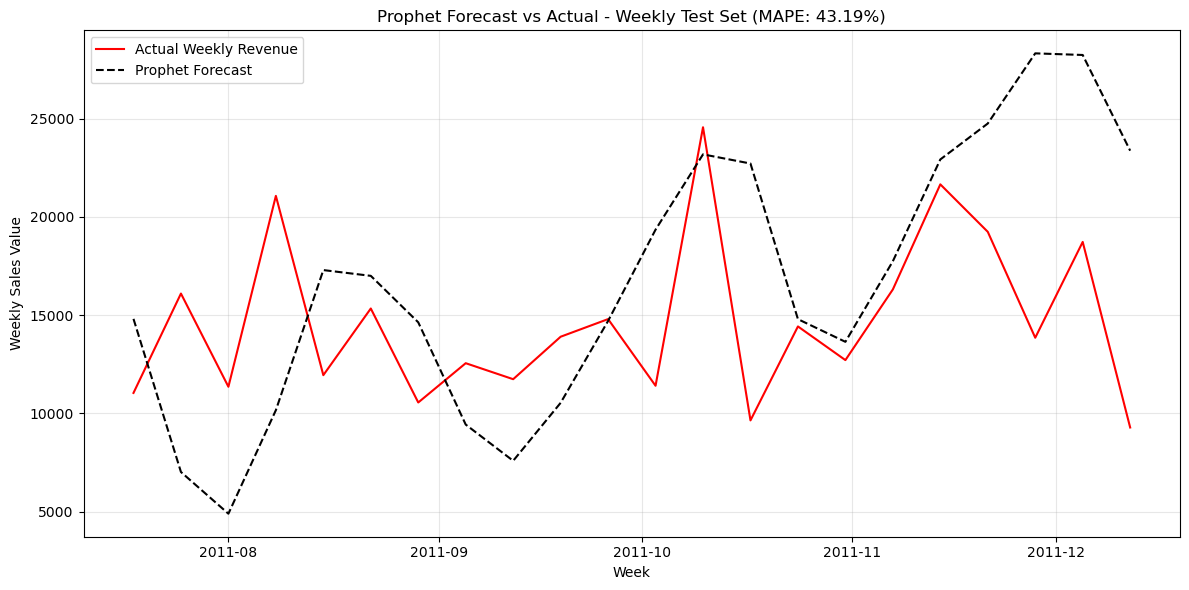

In [ ]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_data['ds'] = pd.to_datetime(test_data['ds'])
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')

test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')
safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_eval['ds'], test_eval['y'], 'r-', label='Actual Weekly Revenue')
plt.plot(test_eval['ds'], test_eval['yhat'], 'k--', label='Prophet Forecast')

plt.title(f'Prophet Forecast vs Actual - Weekly Test Set (MAPE: {mape_test:.2f}%)')
plt.xlabel('Week')
plt.ylabel('Weekly Sales Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Cluster 1

In [38]:
df = pd.read_csv('cluster_1.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

df.set_index('InvoiceDate', inplace=True)
weekly_data = df['Revenue'].resample('W-MON').sum().reset_index()
weekly_data = weekly_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
weekly_data = weekly_data.dropna(subset=['y']).sort_values('ds')

total_weeks = (weekly_data['ds'].max() - weekly_data['ds'].min()).days // 7
test_weeks = int(total_weeks * 0.20)
val_weeks = int(total_weeks * 0.20)

cutoff_test = weekly_data['ds'].max() - pd.Timedelta(weeks=test_weeks)
cutoff_val = cutoff_test - pd.Timedelta(weeks=val_weeks)

train_data = weekly_data[weekly_data['ds'] < cutoff_val].copy()
val_data = weekly_data[(weekly_data['ds'] >= cutoff_val) & (weekly_data['ds'] < cutoff_test)].copy()
test_data = weekly_data[weekly_data['ds'] >= cutoff_test].copy()

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_weeks, freq='W-MON')
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds'])
        val_data['ds'] = pd.to_datetime(val_data['ds'])

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)

        mape_val = merged['ape'].mean()
        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result1 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result1)
print(best_result1['params'])

best_params = best_result1['params']
full_train = weekly_data[weekly_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
m.fit(full_train)

test_weeks = (test_data['ds'].max() - test_data['ds'].min()).days // 7 + 1
future = m.make_future_dataframe(periods=test_weeks, freq='W-MON')
future = future[future['ds'] <= test_data['ds'].max()]
forecast = m.predict(future)

02:01:52 - cmdstanpy - INFO - Chain [1] start processing
02:01:52 - cmdstanpy - INFO - Chain [1] done processing
02:01:52 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 62.020372


02:01:52 - cmdstanpy - INFO - Chain [1] done processing
02:01:53 - cmdstanpy - INFO - Chain [1] start processing
02:01:53 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 93.765591


02:01:53 - cmdstanpy - INFO - Chain [1] start processing
02:01:53 - cmdstanpy - INFO - Chain [1] done processing
02:01:53 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 61.405428


02:01:54 - cmdstanpy - INFO - Chain [1] done processing
02:01:54 - cmdstanpy - INFO - Chain [1] start processing
02:01:54 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


02:01:55 - cmdstanpy - INFO - Chain [1] start processing
02:01:55 - cmdstanpy - INFO - Chain [1] done processing
02:01:55 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 95.189259
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 61.410719


02:01:55 - cmdstanpy - INFO - Chain [1] done processing
02:01:55 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


02:01:55 - cmdstanpy - INFO - Chain [1] done processing
02:01:55 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 94.514086


02:01:55 - cmdstanpy - INFO - Chain [1] done processing
02:01:55 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 61.423869


02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


02:01:56 - cmdstanpy - INFO - Chain [1] done processing
02:01:56 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 94.482619


02:01:57 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 61.428465


02:01:57 - cmdstanpy - INFO - Chain [1] done processing
02:01:57 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


02:01:58 - cmdstanpy - INFO - Chain [1] done processing
02:01:58 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 94.363298


02:01:59 - cmdstanpy - INFO - Chain [1] done processing
02:01:59 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 98.501700


02:01:59 - cmdstanpy - INFO - Chain [1] done processing
02:01:59 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 90.986693


02:02:01 - cmdstanpy - INFO - Chain [1] done processing
02:02:01 - cmdstanpy - INFO - Chain [1] start processing
02:02:01 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 85.260110

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.01, 'seasonality...
MAPE                                              61.405428
Name: 3, dtype: object
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}


In [39]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_data['ds'] = pd.to_datetime(test_data['ds'])
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')

test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')
safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")


--- Final Test Set Evaluation ---
MAPE: 29.2158
MAE : 6348.1344
RMSE: 7419.8893


### Cluster 2

In [41]:
df = pd.read_csv('cluster_2.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Revenue'] = df['Quantity'] * df['Price']

df.set_index('InvoiceDate', inplace=True)
weekly_data = df['Revenue'].resample('W-MON').sum().reset_index()
weekly_data = weekly_data.rename(columns={'InvoiceDate': 'ds', 'Revenue': 'y'})
weekly_data = weekly_data.dropna(subset=['y']).sort_values('ds')

total_weeks = (weekly_data['ds'].max() - weekly_data['ds'].min()).days // 7
test_weeks = int(total_weeks * 0.20)
val_weeks = int(total_weeks * 0.20)

cutoff_test = weekly_data['ds'].max() - pd.Timedelta(weeks=test_weeks)
cutoff_val = cutoff_test - pd.Timedelta(weeks=val_weeks)

train_data = weekly_data[weekly_data['ds'] < cutoff_val].copy()
val_data = weekly_data[(weekly_data['ds'] >= cutoff_val) & (weekly_data['ds'] < cutoff_test)].copy()
test_data = weekly_data[weekly_data['ds'] >= cutoff_test].copy()

param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_mode': ['additive', 'multiplicative'],
    'fourier_order': [5, 10, 15]
}

grid = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results_list = []

for params in grid:
    param_dict = dict(zip(param_names, params))
    try:
        m = Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=param_dict['changepoint_prior_scale'],
            seasonality_mode=param_dict['seasonality_mode']
        )
        m.add_seasonality(name='monthly', period=30.5, fourier_order=param_dict['fourier_order'])
        m.fit(train_data)

        future = m.make_future_dataframe(periods=val_weeks, freq='W-MON')
        forecast = m.predict(future)

        val_forecast = forecast[forecast['ds'] >= cutoff_val][['ds', 'yhat']].copy()
        val_forecast['ds'] = pd.to_datetime(val_forecast['ds'])
        val_data['ds'] = pd.to_datetime(val_data['ds'])

        merged = val_data.merge(val_forecast, on='ds', how='left')
        safe_y = merged['y'].replace(0, 1e-10)
        merged['ape'] = 100 * np.abs((merged['y'] - merged['yhat']) / safe_y)
        merged['ape'] = merged['ape'].replace([np.inf, -np.inf], np.nan).fillna(0).clip(upper=100)

        mape_val = merged['ape'].mean()
        results_list.append({'params': param_dict, 'MAPE': mape_val})
        print(f"Tried {param_dict}, Validation MAPE: {mape_val:.6f}")

    except Exception as e:
        print(f"Error with params {param_dict}: {e}")

results_df = pd.DataFrame(results_list)
best_result2 = results_df.loc[results_df['MAPE'].idxmin()]
print("\nBest Parameters Found (from validation set):")
print(best_result2)
print(best_result2['params'])

best_params = best_result2['params']
full_train = weekly_data[weekly_data['ds'] < cutoff_test].copy()

m = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_mode=best_params['seasonality_mode']
)
m.add_seasonality(name='monthly', period=30.5, fourier_order=best_params['fourier_order'])
m.fit(full_train)

test_weeks = (test_data['ds'].max() - test_data['ds'].min()).days // 7 + 1
future = m.make_future_dataframe(periods=test_weeks, freq='W-MON')
future = future[future['ds'] <= test_data['ds'].max()]
forecast = m.predict(future)

02:03:02 - cmdstanpy - INFO - Chain [1] start processing
02:03:02 - cmdstanpy - INFO - Chain [1] done processing
02:03:02 - cmdstanpy - INFO - Chain [1] start processing
02:03:02 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 67.479175
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:02 - cmdstanpy - INFO - Chain [1] start processing
02:03:02 - cmdstanpy - INFO - Chain [1] done processing
02:03:02 - cmdstanpy - INFO - Chain [1] start processing
02:03:03 - cmdstanpy - INFO - Chain [1] done processing
02:03:03 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000
Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 64.789761


02:03:03 - cmdstanpy - INFO - Chain [1] done processing
02:03:03 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:06 - cmdstanpy - INFO - Chain [1] done processing
02:03:06 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 96.113328


02:03:07 - cmdstanpy - INFO - Chain [1] done processing
02:03:07 - cmdstanpy - INFO - Chain [1] start processing
02:03:07 - cmdstanpy - INFO - Chain [1] done processing
02:03:07 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 67.527965
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:07 - cmdstanpy - INFO - Chain [1] done processing
02:03:07 - cmdstanpy - INFO - Chain [1] start processing
02:03:07 - cmdstanpy - INFO - Chain [1] done processing
02:03:07 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000
Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 66.119888


02:03:08 - cmdstanpy - INFO - Chain [1] done processing
02:03:08 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:09 - cmdstanpy - INFO - Chain [1] done processing
02:03:09 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.1, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 100.000000


02:03:09 - cmdstanpy - INFO - Chain [1] done processing
02:03:09 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 5}, Validation MAPE: 67.480750


02:03:10 - cmdstanpy - INFO - Chain [1] done processing
02:03:10 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:10 - cmdstanpy - INFO - Chain [1] done processing
02:03:10 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'additive', 'fourier_order': 15}, Validation MAPE: 100.000000


02:03:11 - cmdstanpy - INFO - Chain [1] done processing
02:03:11 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}, Validation MAPE: 82.799639


02:03:12 - cmdstanpy - INFO - Chain [1] done processing
02:03:12 - cmdstanpy - INFO - Chain [1] start processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 10}, Validation MAPE: 100.000000


02:03:14 - cmdstanpy - INFO - Chain [1] done processing
02:03:14 - cmdstanpy - INFO - Chain [1] start processing
02:03:14 - cmdstanpy - INFO - Chain [1] done processing


Tried {'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'fourier_order': 15}, Validation MAPE: 100.000000

Best Parameters Found (from validation set):
params    {'changepoint_prior_scale': 0.01, 'seasonality...
MAPE                                              64.789761
Name: 3, dtype: object
{'changepoint_prior_scale': 0.01, 'seasonality_mode': 'multiplicative', 'fourier_order': 5}



--- Final Test Set Evaluation ---
MAPE: 32.5917
MAE : 6178.3178
RMSE: 8393.4988


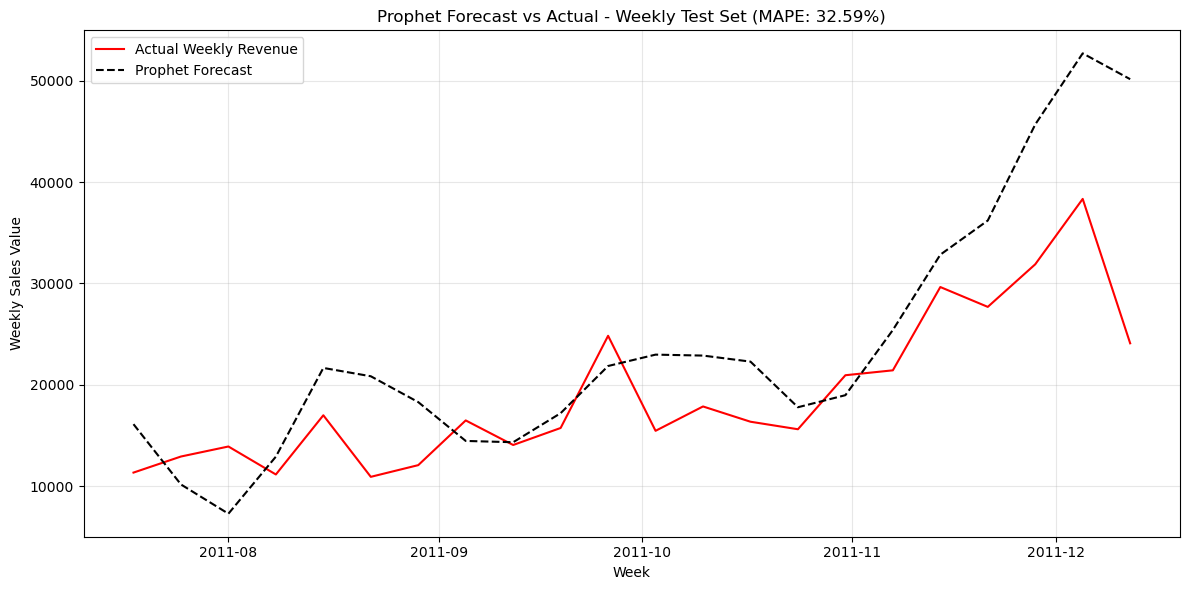

In [23]:
forecast['ds'] = pd.to_datetime(forecast['ds'])
test_data['ds'] = pd.to_datetime(test_data['ds'])
predictions = forecast[forecast['ds'].isin(test_data['ds'])].copy()
predictions = predictions.sort_values('ds')

test_eval = test_data.merge(predictions[['ds', 'yhat']], on='ds', how='left')
safe_y = test_eval['y'].replace(0, 1e-10)
test_eval['ape'] = 100 * np.abs((test_eval['y'] - test_eval['yhat']) / safe_y)
test_eval['ape'] = test_eval['ape'].replace([np.inf, -np.inf], np.nan).fillna(0)

mape_test = test_eval['ape'].mean()
mae_test = np.mean(np.abs(test_eval['y'] - test_eval['yhat']))
rmse_test = np.sqrt(np.mean((test_eval['y'] - test_eval['yhat'])**2))

print("\n--- Final Test Set Evaluation ---")
print(f"MAPE: {mape_test:.4f}")
print(f"MAE : {mae_test:.4f}")
print(f"RMSE: {rmse_test:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(test_eval['ds'], test_eval['y'], 'r-', label='Actual Weekly Revenue')
plt.plot(test_eval['ds'], test_eval['yhat'], 'k--', label='Prophet Forecast')

plt.title(f'Prophet Forecast vs Actual - Weekly Test Set (MAPE: {mape_test:.2f}%)')
plt.xlabel('Week')
plt.ylabel('Weekly Sales Value')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
